# Imports and Setups

In [38]:
import scipy.stats as stats
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import arviz as az
from colorama import Fore
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import chi2, kstest

credentials = service_account.Credentials.from_service_account_file(
    '/Users/kralich/Documents/link-179609-556dd3468699.json',
    scopes=['https://www.googleapis.com/auth/cloud-platform'],)

In [2]:
# This notebook requires gbstats version 0.5.0 or later
try:
    import gbstats.utils
    gbstats.utils.check_gbstats_compatibility('0.5.0')
except ModuleNotFoundError:
    raise ValueError('Upgrade gbstats to 0.5.0 or later from PyPI using `pip install gbstats`')
from gbstats.gbstats import (
    analyze_metric_df,
    detect_unknown_variations,
    get_metric_df,
    reduce_dimensionality,
)
from gbstats.shared.constants import StatsEngine

# Mapping of variation id to index
var_id_map = {'0': 0, '1': 1}

# Display names of variations
var_names = ['Control', 'Variation 1']

# Expected traffic split between variations
weights = [0.5, 0.5]
# Statistics engine to use
stats_engine = StatsEngine.BAYESIAN
# Engine config
engine_config = {}
# Columns to show in the result summary
summary_cols = ['dimension', 'baseline_name', 'baseline_users', 'baseline_cr', 'baseline_risk', 'v1_name', 'v1_users', 'v1_cr', 'v1_expected', 'v1_ci', 'v1_risk', 'v1_prob_beat_baseline']

# Functions

This function generates synthetic population data with a variation assigned to each user

## Population Distribution Generators

### Lognormal Zero-Inflated

In [3]:
def generate_populations(mean_0, sigma_0, mean_1, sigma_1, zero_inflation_0, zero_inflation_1, N=100_000_000):
    # Generate data from a log-normal distribution for each population
    population_0 = np.random.lognormal(mean_0, sigma_0, N)
    population_1 = np.random.lognormal(mean_1, sigma_1, N)

    # Introduce inflated zeros for each population
    zero_indices_0 = np.random.choice(N, size=int(N * zero_inflation_0), replace=False)
    zero_indices_1 = np.random.choice(N, size=int(N * zero_inflation_1), replace=False)
    
    population_0[zero_indices_0] = 0
    population_1[zero_indices_1] = 0

    # Create a dictionary to store populations for iterating
    populations = {0: population_0, 1: population_1}

    # For each population
    for v in populations:
        data_v = populations[v]

        # Check the mean of the generated data
        print(f'Population {v} Mean: {np.mean(data_v)}')

        # Check the standard deviation of the generated data
        print(f'Population {v} Standard Deviation: {np.std(data_v)}')

        # Check the skewness of the generated data
        print(f'Population {v} Skewness: {stats.skew(data_v)}')

        # Check the kurtosis of the generated data
        print(f'Population {v} Kurtosis: {stats.kurtosis(data_v)}')

        # Check the total revenue for each population
        print(f'Population {v} Total Revenue: {np.sum(data_v)}')

        # Check the range of values for each population
        print(f'Population {v} Range: {np.min(data_v)} - {np.max(data_v)}')

        # Plot the histogram of the generated data
        plt.hist(data_v, bins=50, alpha=0.5, density=True)
        plt.title(f'Histogram of generated data for population {v}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.grid(True)
        plt.show()

    # Return the arrays
    return population_0, population_1


### Gaussian (Normal)

In [4]:
def generate_populations_gaussian(mean_0, sigma_0, mean_1, sigma_1, N=100_000_000):
    # Generate data from a normal distribution for each population
    population_0 = np.random.normal(mean_0, sigma_0, N)
    population_1 = np.random.normal(mean_1, sigma_1, N)

    # Create a dictionary to store populations for iterating
    populations = {0: population_0, 1: population_1}

    # For each population
    for v in populations:
        data_v = populations[v]

        # Check the mean of the generated data
        print(f'Population {v} Mean: {np.mean(data_v)}')

        # Check the standard deviation of the generated data
        print(f'Population {v} Standard Deviation: {np.std(data_v)}')

        # Check the skewness of the generated data
        print(f'Population {v} Skewness: {stats.skew(data_v)}')

        # Check the kurtosis of the generated data
        print(f'Population {v} Kurtosis: {stats.kurtosis(data_v)}')

        # Check the total revenue for each population
        print(f'Population {v} Total Revenue: {np.sum(data_v)}')

        # Check the range of values for each population
        print(f'Population {v} Range: {np.min(data_v)} - {np.max(data_v)}')

        # Plot the histogram of the generated data
        plt.hist(data_v, bins=50, alpha=0.5, density=True)
        plt.title(f'Histogram of generated data for population {v}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.grid(True)
        plt.show()

    # Return the arrays
    return population_0, population_1

## Sampling Mean Normality Estimator

Check if the distribution of the sample means converges to normal for the given sample size and population.

In [5]:
def calculate_sample_means(population, sample_size):
    sample_means = []

    # Generate 100,000 samples
    for _ in range(100_000):
        sample = np.random.choice(population, sample_size)
        sample_means.append(sample.mean())

    # Convert the list to a numpy array
    sample_means = np.array(sample_means)

    # Calculate the first four moments
    mean = sample_means.mean()
    variance = sample_means.var()
    skewness = stats.skew(sample_means)
    kurtosis = stats.kurtosis(sample_means)

    # Plot the histogram
    plt.hist(sample_means, bins=50, alpha=0.5, density=True)
    plt.title('Histogram of Sample Means')
    plt.xlabel('Sample Mean')
    plt.ylabel('Density')

    # Print the moments on the histogram
    plt.text(0.6, 0.6, f'Mean: {mean:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.text(0.6, 0.55, f'Variance: {variance:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.text(0.6, 0.5, f'Skewness: {skewness:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.text(0.6, 0.45, f'Kurtosis: {kurtosis:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.grid(True)
    plt.show()


## Difference of Sample Means Normality Estimator

In [196]:
def calculate_sample_mean_differences(population_0, population_1, sample_size):
    t_values = []
    sample_mean_diffs = []
    dof = 2*sample_size - 2  # Calculate degrees of freedom

    # Calculate population parameters outside the loop
    pop_mean_diff = population_1.mean() - population_0.mean() 
    SE_pop = np.sqrt(population_1.std()**2/sample_size + population_0.std()**2/sample_size)
    CI_pop = [pop_mean_diff + multiplier * SE_pop for multiplier in [-1.96, 1.96]]

    # Generate 100,000 samples
    for _ in range(100_000):
        sample_0 = np.random.choice(population_0, sample_size)
        sample_1 = np.random.choice(population_1, sample_size)
        sample_mean_diff = sample_1.mean() - sample_0.mean()
        sample_mean_diffs.append(sample_mean_diff)

        # Standard error calculation
        SE = np.sqrt(sample_0.var()/sample_size + sample_1.var()/sample_size)
        
        # t-value calculation
        t_value = (sample_mean_diff - pop_mean_diff) / SE
        t_values.append(t_value)

    # Convert the list to a numpy array
    sample_mean_diffs = np.array(sample_mean_diffs)
    t_values = np.array(t_values)

    # Count the proportion of sample mean differences outside the boundaries
    outside_CI = np.mean((sample_mean_diffs < CI_pop[0]) | (sample_mean_diffs > CI_pop[1]))

    # Plot the histogram
    plt.hist(sample_mean_diffs, bins=50, alpha=0.5, density=True, label='Observed sample mean differences')

    # Generate values for overlay of the theoretical normal distribution
    x = np.linspace(pop_mean_diff - 4*SE_pop, pop_mean_diff + 4*SE_pop, 100)
    y = stats.norm.pdf(x, pop_mean_diff, SE_pop)

    # Add the theoretical density curve to the plot
    plt.plot(x, y, 'r-', lw=2, label='Theoretical normal distribution')

    plt.title('Histogram of Sample Mean Differences')
    plt.xlabel('Sample Mean Difference')
    plt.ylabel('Density')

    plt.text(0.6, 0.5, f'Proportion outside CI: {outside_CI:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.legend()
    plt.grid(True)
    plt.show()


## Distribution Sampler 

This function samples from the dataframe holding the population and returns two samples in an numpy array

In [6]:
def sample_populations(population_0, population_1, sample_size=1000):
    # Sampling 'sample_size' elements for each population
    sample_0 = np.random.choice(population_0, size=sample_size, replace=False)
    sample_1 = np.random.choice(population_1, size=sample_size, replace=False)
    
    return sample_0, sample_1

## Summary Statistics Calculator

Intermidiary function that calculates summary statistics before feeding them into the growthbook function that understand them. 

In [7]:
def calculate_statistics(array_0, array_1):
    # Calculating revenue and sum squares for each variation
    sum_0 = array_0.sum()
    sum_1 = array_1.sum()

    sum_squares_0 = np.sum(np.square(array_0))
    sum_squares_1 = np.sum(np.square(array_1))

    sample_size_0 = len(array_0)  # Size of the first sample
    sample_size_1 = len(array_1)  # Size of the second sample

    # Creating dataframe for output
    data = {
        'variation': [0, 1],
        'dimension': ['all', 'all'],
        'users': [sample_size_0, sample_size_1],
        'statistic_type': ['mean', 'mean'],
        'main_metric_type': ['revenue', 'revenue'],
        'main_sum': [sum_0, sum_1],
        'main_sum_squares': [sum_squares_0, sum_squares_1]
    }
    result_df = pd.DataFrame(data)

    return result_df

## Growthook Bayesian Analysis

A wrapper function that performs a Bayesian analysis of two samples given the summary 

In [61]:
def bayesian_summary_processor(m0_rows):
    m0 = get_metric_df(
        rows=m0_rows,
        var_id_map={'0': 0, '1': 1},
        var_names=['Control', 'Variation 1'],
    )
    m0_reduced = reduce_dimensionality(m0, max=20)
    m0_result = analyze_metric_df(
        df=m0_reduced,
        weights=[0.5, 0.5],
        inverse=False,
        engine=StatsEngine.BAYESIAN,
        engine_config={},
    )
    return {
        'ci': [round(val, 4) for val in m0_result['v1_ci'][0]],
        'prob': round(m0_result['v1_prob_beat_baseline'][0], 4),
        'control_size': m0_result['baseline_users'][0],
        'treatment_size': m0_result['v1_users'][0]
    }


In [8]:
def bayesian_continuous_growthbook(array_0, array_1):
    
    # Calculate statistics
    stats_df = calculate_statistics(array_0, array_1)

    # Bayesian analysis
    bayes_result = bayesian_summary_processor(stats_df)

    return bayes_result

## Custom Beaysian Analysis

Custom bayesian function for continuous metrics

In [9]:
def custom_bayesian_ab_gaussian(array_0, array_1):
    # Calculating necessary statistics for each variation
    a_mean, a_std, a_size = np.mean(array_0), np.std(array_0, ddof=1), len(array_0)
    b_mean, b_std, b_size = np.mean(array_1), np.std(array_1, ddof=1), len(array_1)

    pr_mean, pr_std, pr_size = 0, 1, 0
    
    weights_inv_var_a = pr_size / np.power(pr_std, 2), a_size / np.power(a_std, 2)
    pt_a_mean = np.average((pr_mean, a_mean), weights=weights_inv_var_a)
    pt_a_std = 1 / np.sqrt(np.sum(weights_inv_var_a)) 
    pt_a_dist = np.random.normal(pt_a_mean, pt_a_std, 1000000)
    
    weights_inv_var_b = pr_size / np.power(pr_std, 2), b_size / np.power(b_std, 2)
    pt_b_mean = np.average((pr_mean, b_mean), weights=weights_inv_var_b)
    pt_b_std = 1 / np.sqrt(np.sum(weights_inv_var_b)) 
    pt_b_dist = np.random.normal(pt_b_mean, pt_b_std, 1000000)
    
    diff_dist = pt_b_dist - pt_a_dist
    
    uplift = (pt_b_dist/pt_a_dist) - 1
 
    exp_loss = round(uplift[uplift < 0].mean(), 2)
    
    ci = az.hdi(uplift, hdi_prob=0.95)
    
    p = round(len(diff_dist[diff_dist > 0]) / len(diff_dist), 6)
    
    p_value = round(1 - p, 6)
    
    readable = "P: " + str(round(p * 100, 2)) + "%; CI: " + str(ci) + "; Uplift: " + str(round(uplift.mean(), 2)) + "%; Loss: " + str(exp_loss) + "%" + ", Group A Mean: " + str(round(a_mean, 2)) + ", Group B Mean: " + str(round(b_mean, 2)) 
    
    if p >= 0.95:
        readable = Fore.GREEN + readable
    else: 
        readable = Fore.BLACK + readable
    
    return {'control_mean': a_mean,
            'treatment_mean': b_mean,
            'control_std': a_std,
            'treatment_std': b_std,
            'control_size': a_size, 
            'treatment_size': b_size, 
            'control_pt_mean': pt_a_mean, 
            'treatment_pt_mean': pt_b_mean,
            'control_pt_std': pt_a_std,
            'treatment_pt_std': pt_b_std,
            'diff_dist': diff_dist,
            'uplift': uplift,
            'uplift_mean': uplift.mean(),
            'prob': p,
            'ci': ci,
            'weights_a': weights_inv_var_a,
            'readable': readable,
            'p_value': p_value,
            'control_conversion': False,
            'treatment_conversion': False
           }


## Classic T-Test Analysis

Classic T-test for analyzing difference between two means

In [10]:
def t_test(array_0, array_1) :
      
    a_mean = array_0.mean()
    b_mean = array_1.mean()
    
    a_size = len(array_0)
    b_size = len(array_1)
    
    a_std = array_0.std(ddof=1)
    b_std = array_1.std(ddof=1)
    
    a_se = a_std / np.sqrt(a_size)
    b_se = b_std / np.sqrt(b_size)
    
    se_diff = np.sqrt(a_se**2.0 + b_se**2.0)
    
    t_stat = (b_mean - a_mean) / se_diff
    
    mean_diff = b_mean - a_mean
    
    df =  a_size + b_size - 2

    critical_t = sp.stats.t.ppf(1.0 - 0.05, df)
    
    ci_critical_t = sp.stats.t.ppf(1.0 - 0.025, df)
    
    ci = [mean_diff - ci_critical_t * se_diff, mean_diff + ci_critical_t * se_diff]
        
    p_value = 1 - sp.stats.t.cdf(t_stat, df)
    
    ci_naive = [ci[0] / a_mean  * 100, ci[1] / a_mean * 100]

    probability = 1 - p_value
       
    readable = "P-value: " + str(round(p_value,2)) + "; CI: " + str(ci) + "; Mean Difference: " + str(round(mean_diff,2)) + "; Mean A: " + str(round(a_mean,2)) + "; Mean B: " + str(round(b_mean,2))
    
    if p_value <= 0.05 :
        readable = Fore.GREEN + readable
    else: 
        readable = Fore.BLACK + readable
    
    return {'control_mean': round(a_mean, 4),
            'treatment_mean': round(b_mean, 4),
            'control_std': round(a_std, 4),
            'control_se': round(a_se, 4),
            'treatment_std': round(b_std, 4),
            'treatment_se': round(b_se, 4),
            'control_size': a_size, 
            'treatment_size': b_size, 
            'control_pt_mean': round(a_mean, 4), 
            'treatment_pt_mean': round(b_mean, 4),
            'control_pt_std': round(a_std, 4),
            'control_pt_se': round(a_se, 4),
            'treatment_pt_std': round(b_std, 4),
            'treatment_pt_se': round(b_se, 4),
            'control_pt_dist': None,
            'diff_dist': None,
            'standard_error_difference': round(se_diff, 4),
            'uplift': None,
            'uplift_mean': None,
            'p': None,
            'observed_mean_difference':round(mean_diff,4), 
            'ci': [round(ci[0], 4), round(ci[1], 4)],
            'weights_a': None,
            'readable' : readable,
            'p_value' : round(p_value, 4),
            'critical_t': round(critical_t, 4),
            'prob': round(probability, 4),
            'readable': readable
           }


## Experiment Iterator

Function performs a specified number of A/B tests by repeatedly taking samples from the population distribution.it prints out thre results of each A/B test and a summary

In [11]:
def iterate_and_print(iterations, population_0, population_1, sample_size=5000, analysis_function=bayesian_continuous_growthbook):
    mean_0 = round(population_0.mean(), 4)
    mean_1 = round(population_1.mean(), 4)
    uplift = round((mean_1 / mean_0) - 1, 4)
    
    mean_diff = mean_1 - mean_0
    obs_mean_diff = False
    
    count_true = 0  # Initialize a counter for 'True' results
    count_win = 0
    for i in range(iterations):
        
        sample_0, sample_1 = sample_populations(population_0, population_1, sample_size)
        
        m0_result = analysis_function(sample_0, sample_1)
        
        ci = m0_result['ci']
        prob = m0_result['prob']
        baseline_users = m0_result['control_size']
        v1_users = m0_result['treatment_size']
        
        # Check for inclusion based on the analysis function used
        if analysis_function == t_test:
            contains_true_value = ci[0] <= mean_diff <= ci[1]
            obs_mean_diff = m0_result['observed_mean_difference']
        else:
            contains_true_value = ci[0] <= uplift <= ci[1]
        
        print(f"{i+1}. Users: {baseline_users}; Real Uplift: {uplift}, Real Diff: {mean_diff}; Observed Diff: {obs_mean_diff}; In Inteval: {contains_true_value}, CI = {ci}; P: {prob}")

        # If the result is True, increment the counter
        if contains_true_value:
            count_true += 1
             
        if prob >= 0.95:
            count_win += 1
            
    # After all iterations, print the proportion of 'True' results
    proportion_true = round(count_true / iterations, 4)
    proportion_winners = round(count_win / iterations, 4)
    print(f"Proportion of times 'contains_true_uplift' was True: {proportion_true}")
    print(f"Proportion of winners: {proportion_winners}")


## Sample Mean Estimator

This function visualizes the difference of the sample mean distribution and also plots confidence intervals obtained during the simulation, along with some summary

In [ ]:
def plot_sample_mean_diffs(population_a, population_b, sample_size, num_samples=100_000):
    sample_mean_diffs = []
    ci_low = []
    ci_high = []
    overshoot_count = 0
    undershoot_count = 0

    # Calculate the theoretical distribution parameters
    mean_diff = population_b.mean() - population_a.mean()

    # Draw samples and calculate mean differences
    for _ in range(num_samples):
        sample_a = np.random.choice(population_a, sample_size)
        sample_b = np.random.choice(population_b, sample_size)
        sample_mean_diff = sample_b.mean() - sample_a.mean()
        sample_mean_diffs.append(sample_mean_diff)

        # Calculate standard error for the difference of means
        se_diff = np.sqrt(sample_a.var()/sample_size + sample_b.var()/sample_size)

        # Calculate confidence intervals for the difference of means
        df = sample_size - 1  # degrees of freedom for the t-distribution
        ci = stats.t.interval(0.95, df, loc=sample_mean_diff, scale=se_diff)
        ci_low.append(ci[0])
        ci_high.append(ci[1])

        if ci[0] > mean_diff:
            overshoot_count += 1
        elif ci[1] < mean_diff:
            undershoot_count += 1

    # Convert to numpy array for easier calculations
    sample_mean_diffs = np.array(sample_mean_diffs)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    std_error_diff = np.sqrt(population_a.var()/sample_size + population_b.var()/sample_size)

    # Calculate 2.5th and 97.5th percentiles of the theoretical distribution
    low_percentile = stats.norm.ppf(0.025, mean_diff, std_error_diff)
    high_percentile = stats.norm.ppf(0.975, mean_diff, std_error_diff)

    # Count the number of sample mean differences that fall outside the percentiles
    outside_percentiles = np.sum((sample_mean_diffs < low_percentile) | (sample_mean_diffs > high_percentile))
    outside_percentiles_percent = outside_percentiles / num_samples

    # Print percentile values
    print(f'2.5th percentile: {low_percentile:.2f}')
    print(f'97.5th percentile: {high_percentile:.2f}')

    # Print summary statistics
    print(f'Mean of sample mean differences: {np.mean(sample_mean_diffs):.2f}')
    print(f'Standard deviation of sample mean differences: {np.std(sample_mean_diffs):.2f}')
    print(f'Skewness of sample mean differences: {stats.skew(sample_mean_diffs):.2f}')
    print(f'Kurtosis of sample mean differences: {stats.kurtosis(sample_mean_diffs):.2f}')

    # Plot histogram of sample mean differences
    plt.hist(sample_mean_diffs, bins=50, alpha=0.5, density=True, label='Observed sample mean differences')

    # Overlay the theoretical normal distribution
    x_values = np.linspace(mean_diff - 4*std_error_diff, mean_diff + 4*std_error_diff, 100)
    y_values = stats.norm.pdf(x_values, mean_diff, std_error_diff)
    plt.plot(x_values, y_values, 'r-', lw=2, label='Theoretical normal distribution')

    # Highlight 2.5th and 97.5th percentile
    plt.axvline(x=low_percentile, color='g', linestyle='--', label='2.5th percentile')
    plt.axvline(x=high_percentile, color='g', linestyle='--', label='97.5th percentile')

    plt.title('Histogram of Sample Mean Differences')
    plt.xlabel('Sample Mean Difference')
    plt.ylabel('Density')
    plt.text(0.6, 0.6, f'Proportion outside percentiles: {outside_percentiles_percent:.2f}', 
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot confidence intervals
    plt.figure(figsize=(12,5))
    plt.errorbar(range(num_samples), sample_mean_diffs, yerr=[sample_mean_diffs-ci_low, ci_high-sample_mean_diffs], fmt='o', alpha=0.5)
    plt.axhline(mean_diff, color='r', linestyle='--', label='True mean difference')
    plt.title('Confidence Intervals of Sample Mean Differences')
    plt.xlabel('Sample')
    plt.ylabel('Mean Difference')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Count the number of confidence intervals that failed to contain the true mean difference
    ci_fail_count = np.sum((ci_low > mean_diff) | (ci_high < mean_diff))
    ci_fail_proportion = ci_fail_count / num_samples

    # Print the proportion of confidence intervals that failed to contain the true mean difference, overshoot and undershoot
    print(f'Proportion of confidence intervals that failed to contain the true mean difference: {ci_fail_proportion:.2f}')
    print(f'Proportion of confidence intervals that overshoot the true mean difference: {overshoot_count/num_samples:.2f}')
    print(f'Proportion of confidence intervals that undershoot the true mean difference: {undershoot_count/num_samples:.2f}')

    # Return the sample mean differences and their confidence intervals
    return True


## Query Runner

Function for retrieving real experiment data from Big Query

In [ ]:
def runQuery(sql) :
    return pd.read_gbq(sql, credentials=credentials)

In [49]:
credentials = service_account.Credentials.from_service_account_file(
    '/Users/kralich/Documents/link-179609-556dd3468699.json',
    scopes=['https://www.googleapis.com/auth/cloud-platform'],)


def runQuery(sql) :
    return pd.read_gbq(sql, credentials=credentials)

# Data Generation

### Synthetic Population Data for Analysis

Population 0 Mean: 19.99993811617028
Population 0 Standard Deviation: 0.9999278714700267
Population 0 Skewness: 0.0002490844582293766
Population 0 Kurtosis: 0.0001624597930698357
Population 0 Total Revenue: 1999993811.6170282
Population 0 Range: 14.378955756477554 - 25.516551165258257


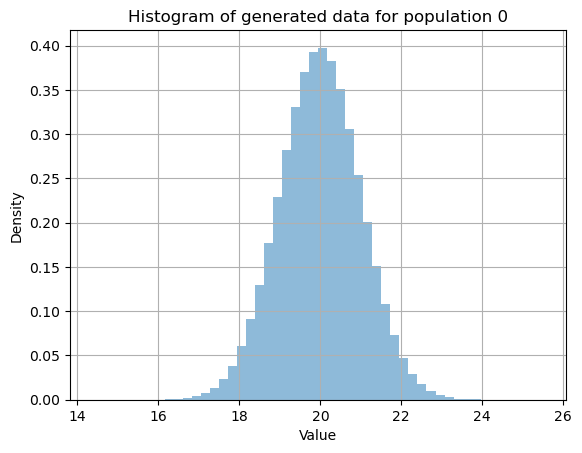

Population 1 Mean: -3.121228486438137e-06
Population 1 Standard Deviation: 0.9999939032503863
Population 1 Skewness: -0.00010206722057229626
Population 1 Kurtosis: -0.00010241397811583397
Population 1 Total Revenue: -312.1228486438137
Population 1 Range: -5.965665598326132 - 5.527393315342016


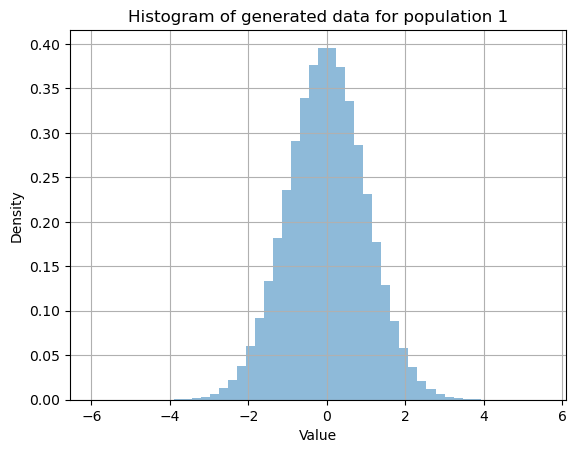

In [73]:
population_0, population_1 = generate_populations_gaussian(20, 1, 0, 1, 100_000_000)

In [37]:
m0_rows = sample_and_calculate(synthetic_data)
display(m0_rows)

,variation,dimension,users,statistic_type,main_metric_type,main_sum,main_sum_squares
0,0,all,1000,mean,revenue,558.702731,91678.051219
1,1,all,1000,mean,revenue,596.890923,19742.716477


### Real Experiment Data

In [54]:
# Get aggregate metric values per dimension/variation
m0_sql = """-- [Service V2] Revenue Per User (revenue)
WITH
  __rawExperiment as (
    SELECT
      CAST(user_id AS INT64) AS user_id,
      CAST(created_at AS DATETIME) AS timestamp,
      REGEXP_EXTRACT(experiment_id_variation, r"(.*)\\.") AS experiment_id,
      REGEXP_EXTRACT(experiment_id_variation, r"\\.(.*)") AS variation_id,
      event_name,
      country,
      lang,
      device_category,
      window_type,
      window_name
    FROM
      `sendpulse_normalized.events`,
      UNNEST (SPLIT(experiment_groups, "!")) AS experiment_id_variation
    WHERE
      stream_id = "3570165827"
      AND experiment_groups IS NOT NULL
      AND DATE(created_at) >= "2023-01-01"
  ),
  __experiment as ( -- Viewed Experiment
    SELECT
      e.user_id as user_id,
      cast(e.variation_id as string) as variation,
      CAST(e.timestamp as DATETIME) as timestamp,
      CAST(e.timestamp as DATETIME) as conversion_start,
      DATETIME_ADD(CAST(e.timestamp as DATETIME), INTERVAL 168 HOUR) as conversion_end
    FROM
      __rawExperiment e
    WHERE
      e.experiment_id = 'plans_after_survery'
      AND CAST(e.timestamp as DATETIME) >= DATETIME("2023-05-17 08:38:00")
      AND CAST(e.timestamp as DATETIME) <= DATETIME("2023-07-12 16:55:30")
      AND (e.user_id >= 8342854)
  ),
  __metric as ( -- Metric ([Service V2] Revenue Per User)
    SELECT
      user_id as user_id,
      m.value as value,
      CAST(m.timestamp as DATETIME) as timestamp,
      CAST(m.timestamp as DATETIME) as conversion_start,
      CAST(m.timestamp as DATETIME) as conversion_end
    FROM
      (
        SELECT
          CAST(user_id AS INT64) AS user_id,
          CAST(created_at AS DATETIME) AS timestamp,
          value
        FROM
          `sendpulse_normalized.events`
        WHERE
          event_name = "pricing_plan_activated"
          AND stream_id = '3570165827'
      ) m
    WHERE
      CAST(m.timestamp as DATETIME) >= DATETIME("2023-05-17 08:38:00")
      AND CAST(m.timestamp as DATETIME) <= DATETIME("2024-06-29 12:07:00")
  ),
  __distinctUsers as (
    -- One row per user
    SELECT
      e.user_id as user_id,
      cast('All' as string) as dimension,
      (
        CASE
          WHEN count(distinct e.variation) > 1 THEN '__multiple__'
          ELSE max(e.variation)
        END
      ) as variation,
      MIN(e.conversion_start) as conversion_start,
      MIN(e.conversion_end) as conversion_end
    FROM
      __experiment e
    GROUP BY
      e.user_id
  ),
  __userMetricJoin as (
    SELECT
      d.variation AS variation,
      d.dimension AS dimension,
      d.user_id AS user_id,
      (
        CASE
          WHEN m.timestamp >= d.conversion_start
          AND m.timestamp <= d.conversion_end THEN m.value
          ELSE NULL
        END
      ) as value
    FROM
      __distinctUsers d
      LEFT JOIN __metric m ON (m.user_id = d.user_id)
  ),
  __userMetricAgg as (
    -- Add in the aggregate metric value for each user
    SELECT
      variation,
      dimension,
      user_id,
      SUM(COALESCE(value, 0)) as value
    FROM
      __userMetricJoin
    GROUP BY
      variation,
      dimension,
      user_id
  )
  -- One row per variation/dimension with aggregations
SELECT
  m.variation AS variation,
  m.dimension AS dimension,
  COUNT(*) AS users,
  'mean' as statistic_type,
  'revenue' as main_metric_type,
  SUM(COALESCE(m.value, 0)) AS main_sum,
  SUM(POWER(COALESCE(m.value, 0), 2)) AS main_sum_squares
FROM
  __userMetricAgg m
GROUP BY
  m.variation,
  m.dimension"""

m0_rows = runQuery(m0_sql)
display(m0_rows)

,variation,dimension,users,statistic_type,main_metric_type,main_sum,main_sum_squares
0,1,All,8793,mean,revenue,17335.13,8.336605e+06
1,0,All,8751,mean,revenue,17936.91,2.248242e+07


## Data Quality Checks / Preparation

In [38]:
# Identify any variation ids returned from SQL that we aren't expecting
unknown_var_ids = detect_unknown_variations(
    rows=m0_rows,
    var_id_map=var_id_map
)
print("Unexpected variation ids: ", unknown_var_ids)

Unexpected variation ids:  set()


In [23]:
# Process raw SQL rows into a usable dataframe for analysis
m0 = get_metric_df(
    rows=m0_rows,
    var_id_map=var_id_map,
    var_names=var_names,
)
display(m0)

,dimension,variations,statistic_type,main_metric_type,denominator_metric_type,covariate_metric_type,total_users,baseline_id,baseline_name,baseline_users,...,v1_users,v1_count,v1_main_sum,v1_main_sum_squares,v1_denominator_sum,v1_denominator_sum_squares,v1_main_denominator_sum_product,v1_covariate_sum,v1_covariate_sum_squares,v1_main_covariate_sum_product
0,all,2,mean,revenue,None,None,2000,0,Control,1000,...,1000,1000,521.969066,50144.863955,0,0,0,0,0,0


In [24]:
# If there are too many dimensions, merge the smaller ones together
m0_reduced = reduce_dimensionality(m0, max=20)
display(m0_reduced)

,dimension,variations,statistic_type,main_metric_type,denominator_metric_type,covariate_metric_type,total_users,baseline_id,baseline_name,baseline_users,...,v1_users,v1_count,v1_main_sum,v1_main_sum_squares,v1_denominator_sum,v1_denominator_sum_squares,v1_main_denominator_sum_product,v1_covariate_sum,v1_covariate_sum_squares,v1_main_covariate_sum_product
0,all,2,mean,revenue,None,None,2000,0,Control,1000,...,1000,1000,521.969066,50144.863955,0,0,0,0,0,0


### Result

In [25]:
# Run the analysis and show a summary of results
m0_result = analyze_metric_df(
    df=m0_reduced,
    weights=weights,
    inverse=False,
    engine=stats_engine,
    engine_config=engine_config,
)
display(m0_result[summary_cols].T)

,0
dimension,all
baseline_name,Control
baseline_users,1000
baseline_cr,0.583535
baseline_risk,0
v1_name,Variation 1
v1_users,1000
v1_cr,0.521969
v1_expected,-0.105505
v1_ci,"[0, 0]"


In [120]:
(population_1.mean() / population_0.mean()) - 1

14.050473778316276

In [321]:
iterate_and_print(100,population_0, population_1,1000)

1. Users: 1000; Real Uplift: 5.8291, Real Diff: 2.8644; Observed Diff: False; In Inteval: True, CI = [1.9366, 6.3412]; P: 1.0
2. Users: 1000; Real Uplift: 5.8291, Real Diff: 2.8644; Observed Diff: False; In Inteval: True, CI = [2.7458, 7.956]; P: 1.0
3. Users: 1000; Real Uplift: 5.8291, Real Diff: 2.8644; Observed Diff: False; In Inteval: True, CI = [4.0433, 11.0647]; P: 1.0
4. Users: 1000; Real Uplift: 5.8291, Real Diff: 2.8644; Observed Diff: False; In Inteval: True, CI = [3.5107, 12.6673]; P: 1.0
5. Users: 1000; Real Uplift: 5.8291, Real Diff: 2.8644; Observed Diff: False; In Inteval: True, CI = [3.3841, 8.9754]; P: 1.0
6. Users: 1000; Real Uplift: 5.8291, Real Diff: 2.8644; Observed Diff: False; In Inteval: True, CI = [3.7824, 10.116]; P: 1.0
7. Users: 1000; Real Uplift: 5.8291, Real Diff: 2.8644; Observed Diff: False; In Inteval: False, CI = [0, 0]; P: 0.5
8. Users: 1000; Real Uplift: 5.8291, Real Diff: 2.8644; Observed Diff: False; In Inteval: True, CI = [2.543, 8.7542]; P: 1.0
9

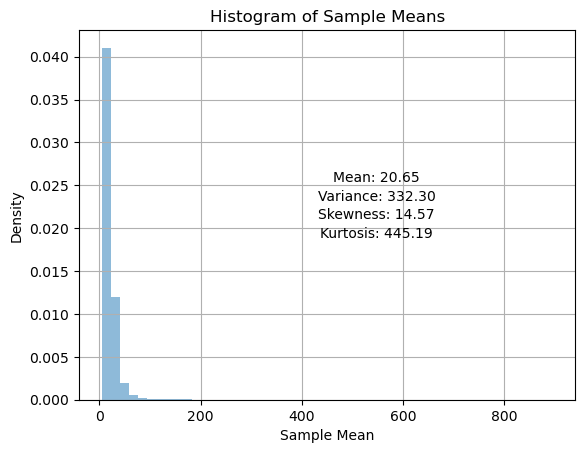

In [ ]:
calculate_sample_means(population_1, 1000)

2.5th percentile: -0.12
97.5th percentile: 4.23
Mean of sample mean differences: 2.05
Standard deviation of sample mean differences: 1.06
Skewness of sample mean differences: 5.09
Kurtosis of sample mean differences: 61.22


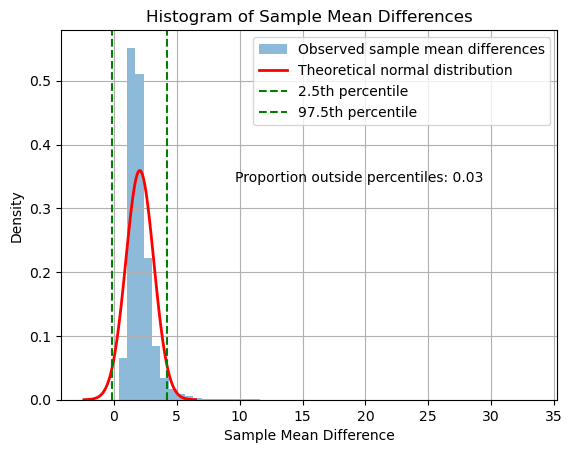

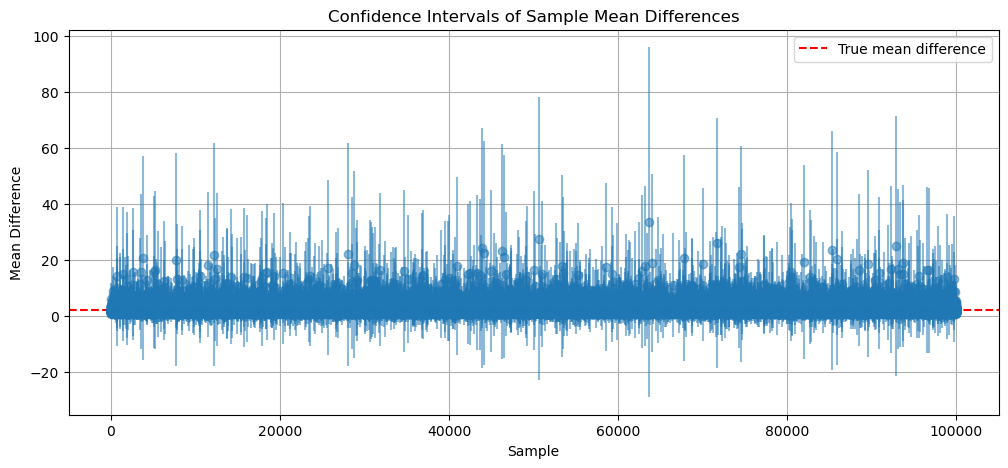

Proportion of confidence intervals that failed to contain the true mean difference: 0.20
Proportion of confidence intervals that overshoot the true mean difference: 0.00
Proportion of confidence intervals that undershoot the true mean difference: 0.20


True

In [29]:
plot_sample_mean_diffs(population_0, population_1, sample_size=1000, num_samples=100000)

In [68]:
def estimate_population_variance(population, sample_size, num_iterations):
    population_variance = np.var(population, ddof=0)  # population variance
    sample_variances = []

    # Perform the sampling process
    for _ in range(num_iterations):
        sample = np.random.choice(population, sample_size)
        sample_variance = np.var(sample, ddof=1)  # Using Bessel's correction (ddof=1)
        sample_variances.append((sample_size - 1) * sample_variance)

    # Convert to numpy array for easier calculations
    sample_variances = np.array(sample_variances)

    # Plot histogram of scaled sample variances
    plt.hist(sample_variances, bins=50, alpha=0.5, density=True, label='Observed scaled sample variances')

    # Overlay the theoretical chi-square distribution
    df = sample_size - 1  # degrees of freedom for the chi-square distribution
    x_values = np.linspace(0, np.max(sample_variances), 100)
    y_values = stats.chi2.pdf(x_values, df)
    plt.plot(x_values, y_values, 'r-', lw=2, label='Theoretical chi-square distribution')

    plt.title('Histogram of Scaled Sample Variances')
    plt.xlabel('Scaled Sample Variance')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    return sample_variances


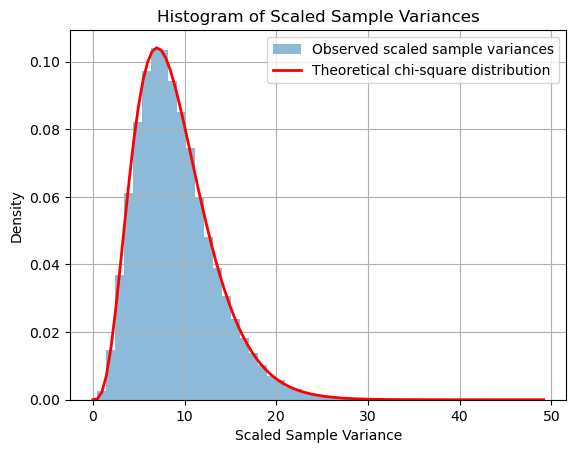

In [74]:
sample_variances = estimate_population_variance(population_0, 10, 100000)

In [78]:
ks_statistic, p_value = kstest(sample_variances, 'chi2', args=(10-1,))

In [79]:
print(p_value)

0.40458037784846446
